# Alpha power : Sleep I vs Sleep II

**Question** : Est-ce que le niveau d'activité alpha change entre le sommeil *avant* la tâche d'apprentissage (Sleep I / NREM I) et le sommeil *après* (Sleep II / NREM II) ?

**Approche**

1. Pour chaque epoch NREM on calcule l'enveloppe instantanée de la bande alpha (8–13 Hz) via filtre Butterworth + transformée de Hilbert.
2. On extrait la puissance alpha moyenne de chaque epoch.
3. On compare les deux groupes visuellement et quantitativement.

Régions disponibles : `dHPC_lfp` (hippocampe dorsal), `vHPC_lfp` (hippocampe ventral), `bla_lfp` (amygdale).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import welch

# Core functions built for this project
from core import (
    detect_significant_band_epochs,
    plot_band_activity,
    FREQ_BANDS,
)

FS = 1250  # Hz — sampling frequency

## 1. Chargement des données

In [2]:
df = pd.read_pickle("data/lfp_epochs_with_spikes_by_region-rw-2.pkl")

print("Epoch labels disponibles :", sorted(df["epoch_label"].unique()))
print()

summary = df.groupby("epoch_label").apply(
    lambda g: pd.Series({
        "n_epochs": len(g),
        "total_duration_s": (g["t_end"] - g["t_start"]).sum().round(1),
        "mean_duration_s" : (g["t_end"] - g["t_start"]).mean().round(1),
    })
)
print(summary)

Epoch labels disponibles : ['NREM I', 'NREM II', 'REM I', 'REM II']

             n_epochs  total_duration_s  mean_duration_s
epoch_label                                             
NREM I          184.0            5555.0             30.2
NREM II         203.0            5128.0             25.3
REM I           178.0            2651.0             14.9
REM II          193.0            2164.0             11.2


In [3]:
nrem1 = df[df["epoch_label"] == "NREM I"].reset_index(drop=True)
nrem2 = df[df["epoch_label"] == "NREM II"].reset_index(drop=True)
rem1  = df[df["epoch_label"] == "REM I"].reset_index(drop=True)
rem2  = df[df["epoch_label"] == "REM II"].reset_index(drop=True)

for name, grp in [("NREM I", nrem1), ("NREM II", nrem2), ("REM I", rem1), ("REM II", rem2)]:
    print(f"{name} : {len(grp)} epochs — durées : {[int(r['t_end']-r['t_start']) for _, r in grp.iterrows()]} s")


NREM I : 184 epochs — durées : [8, 15, 42, 9, 28, 12, 10, 18, 11, 25, 14, 10, 9, 18, 7, 12, 15, 11, 4, 36, 24, 15, 2, 49, 10, 62, 20, 24, 63, 9, 2, 16, 9, 1, 9, 16, 5, 2, 6, 13, 4, 11, 18, 2, 9, 13, 14, 13, 5, 24, 5, 24, 8, 9, 27, 7, 9, 45, 38, 6, 38, 17, 31, 22, 15, 28, 18, 3, 6, 12, 100, 50, 15, 4, 17, 42, 36, 8, 5, 30, 4, 6, 7, 5, 2, 4, 9, 2, 7, 8, 9, 5, 8, 9, 18, 6, 12, 8, 24, 21, 11, 15, 13, 11, 66, 65, 7, 11, 84, 35, 210, 14, 7, 5, 99, 10, 98, 47, 33, 25, 31, 27, 118, 13, 326, 62, 49, 74, 70, 39, 26, 83, 31, 41, 3, 21, 24, 46, 23, 25, 424, 3, 5, 86, 38, 20, 176, 30, 102, 111, 11, 30, 41, 34, 125, 5, 8, 86, 6, 84, 124, 10, 2, 28, 28, 23, 13, 9, 8, 8, 9, 15, 18, 12, 86, 10, 14, 18, 4, 3, 7, 7, 5, 38] s
NREM II : 203 epochs — durées : [52, 96, 10, 10, 185, 27, 60, 10, 32, 14, 35, 9, 9, 11, 3, 7, 10, 13, 135, 10, 5, 78, 14, 8, 15, 9, 4, 11, 9, 9, 5, 6, 4, 5, 13, 18, 8, 28, 10, 15, 24, 44, 4, 10, 12, 19, 29, 9, 23, 3, 28, 16, 15, 8, 2, 20, 30, 43, 135, 6, 108, 36, 49, 2, 3, 3, 6, 190,

## 2. Inspection visuelle — une epoch de chaque condition

On utilise `plot_band_activity` pour voir où les bandes theta, alpha et beta
sont actives sur une fenêtre de 30 secondes.
Les zones colorées (orange = theta, vert = alpha, bleu = beta) marquent les
instants où l'enveloppe dépasse le seuil (75e percentile par défaut).

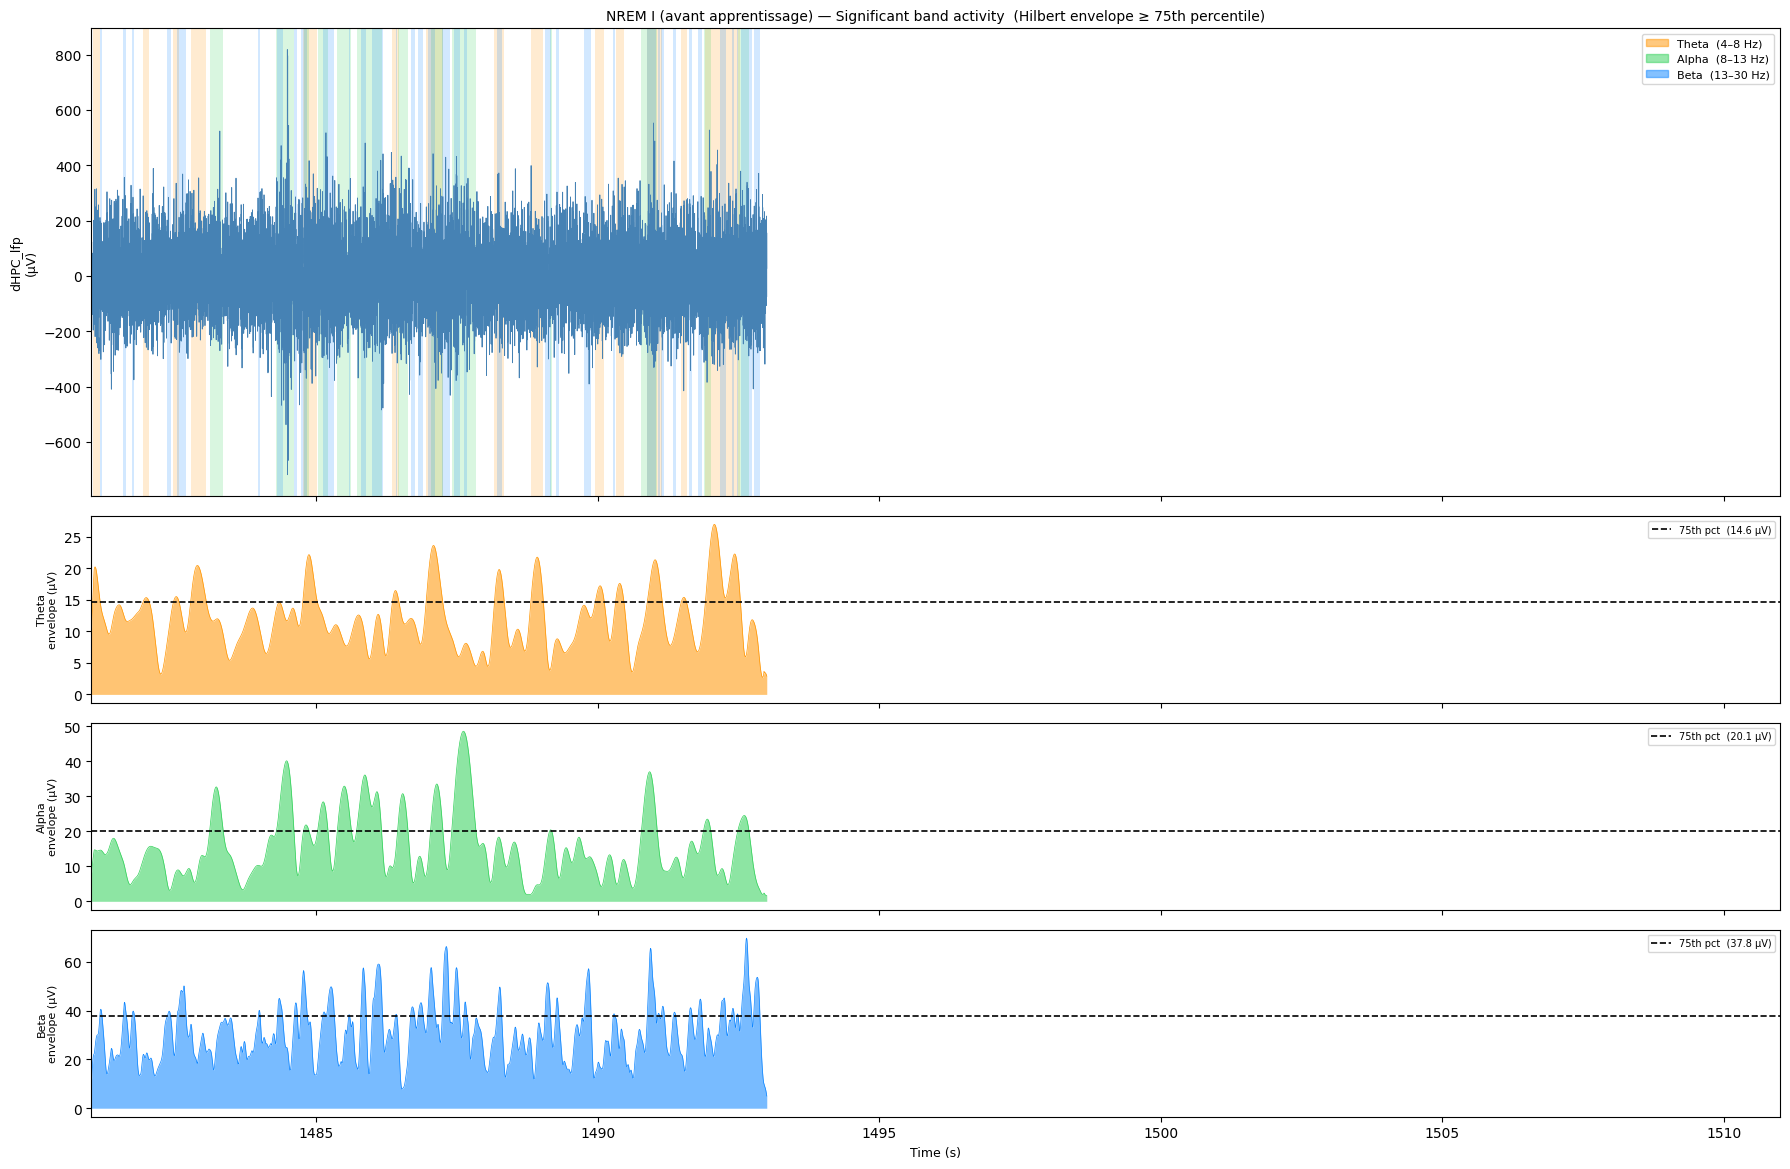

In [4]:
# --- NREM I  (avant apprentissage) — epoch idx=5, fenêtre de 30 s ---
epoch_pre  = nrem1[nrem1["epoch_idx"] == 5].iloc[0]

fig_pre = plot_band_activity(
    epoch_row=epoch_pre,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_pre["t_start"], epoch_pre["t_start"] + 30),
    title_prefix="NREM I (avant apprentissage)",
)
plt.show()

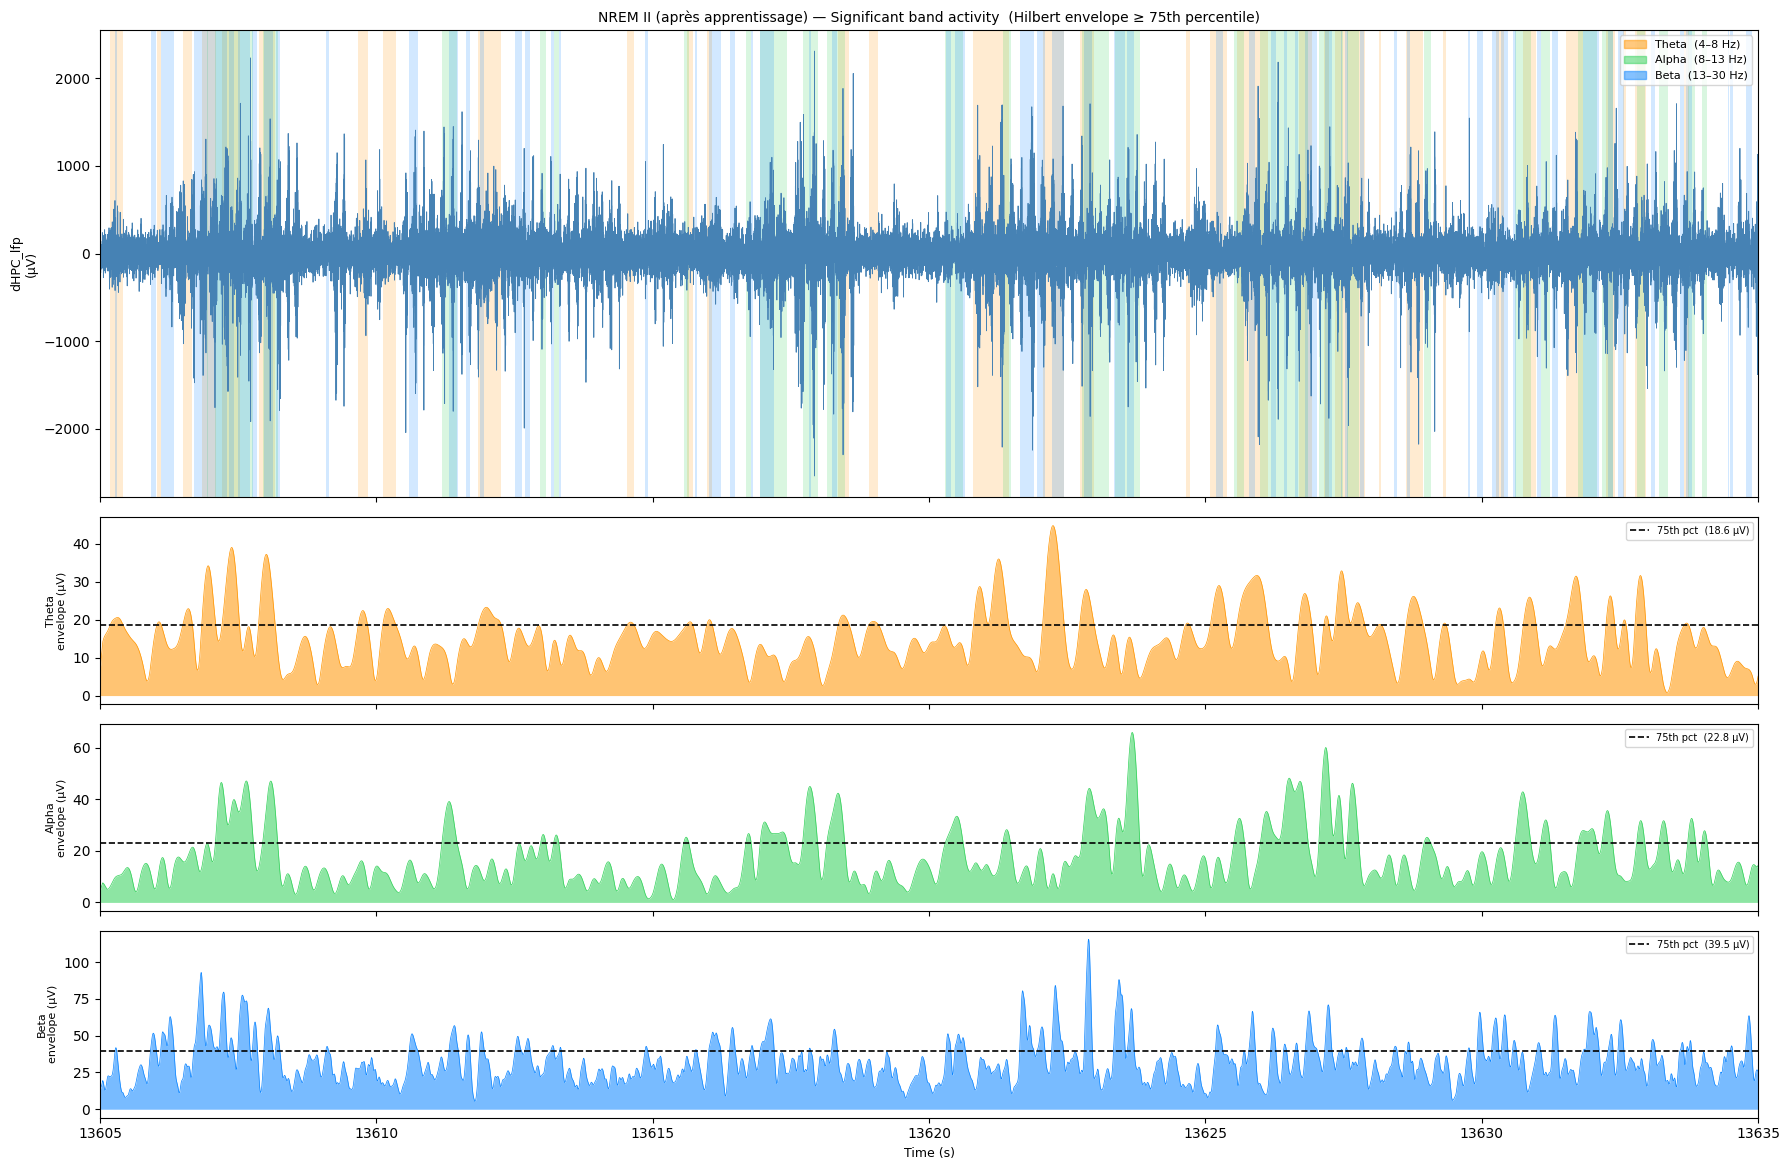

In [5]:
# --- NREM II (après apprentissage) — epoch idx=1, fenêtre de 30 s ---
epoch_post = nrem2[nrem2["epoch_idx"] == 1].iloc[0]

fig_post = plot_band_activity(
    epoch_row=epoch_post,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_post["t_start"], epoch_post["t_start"] + 30),
    title_prefix="NREM II (après apprentissage)",
)
plt.show()

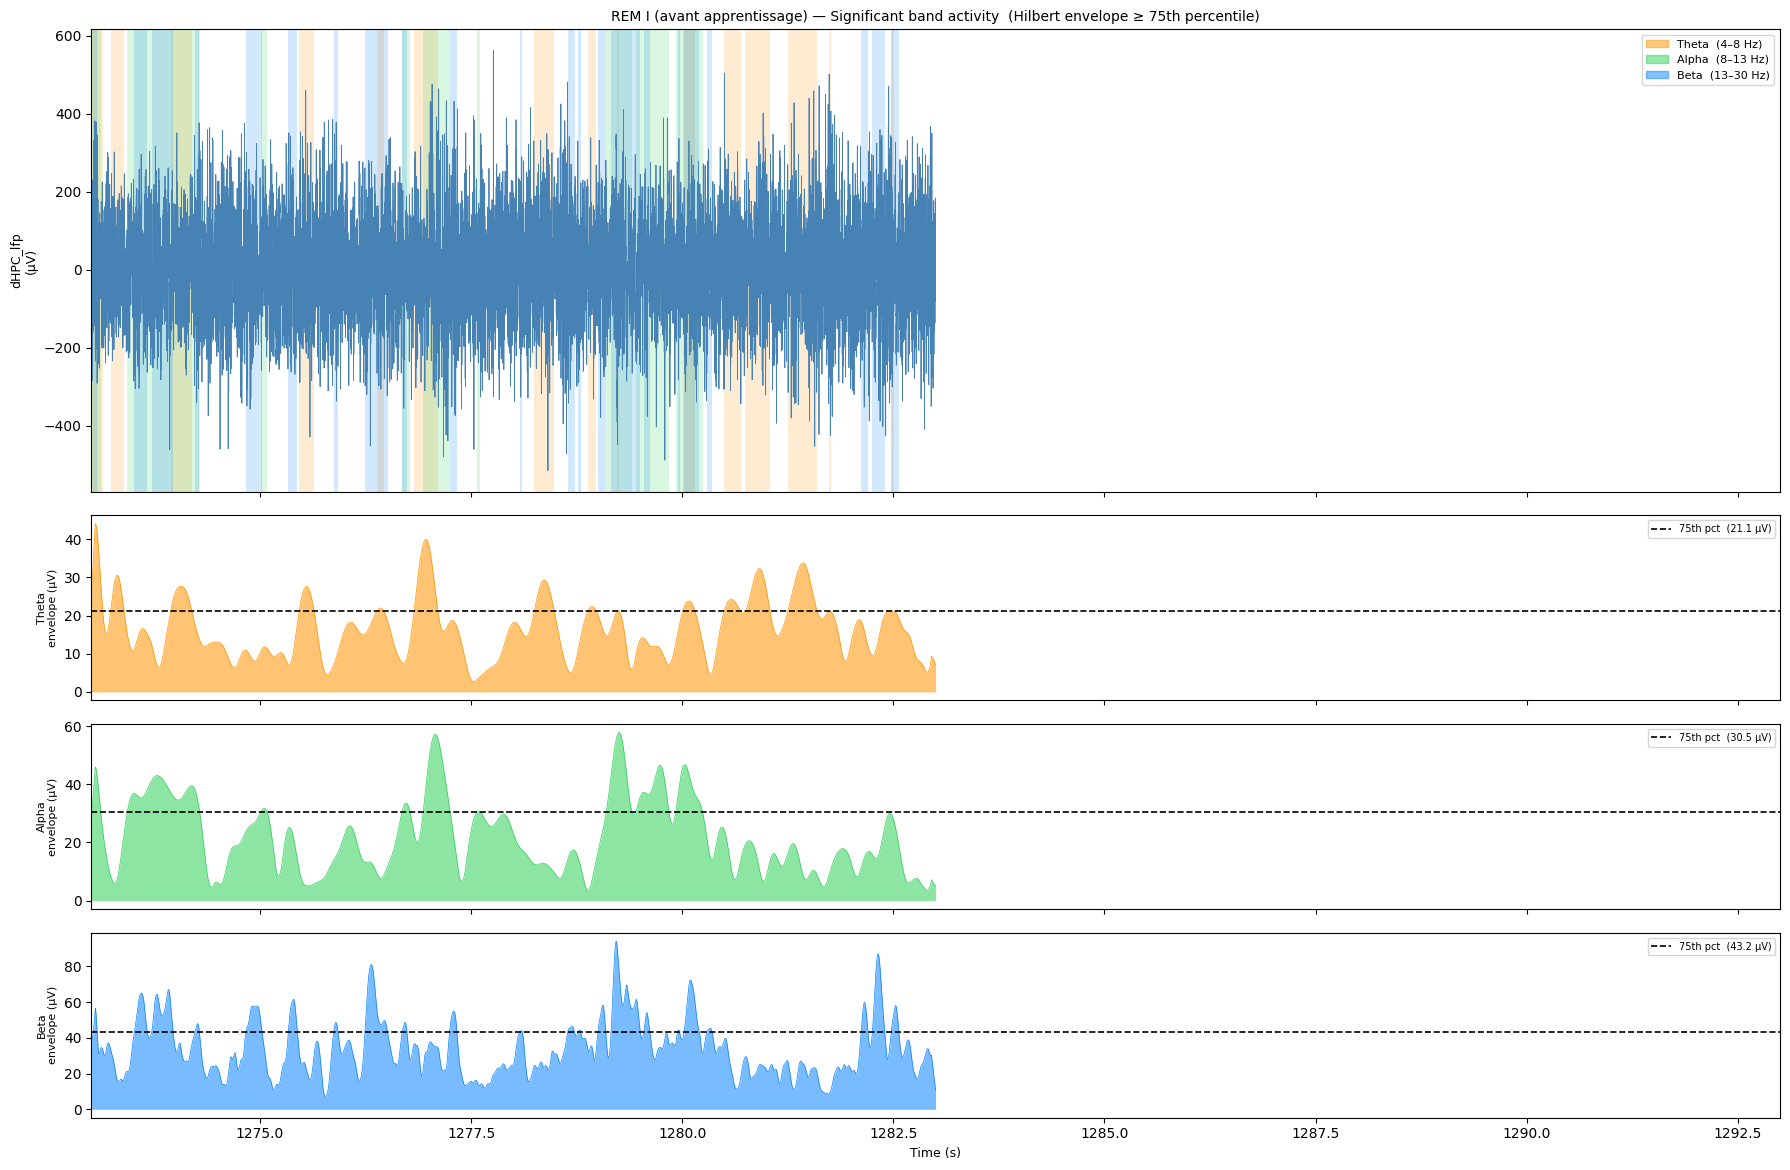

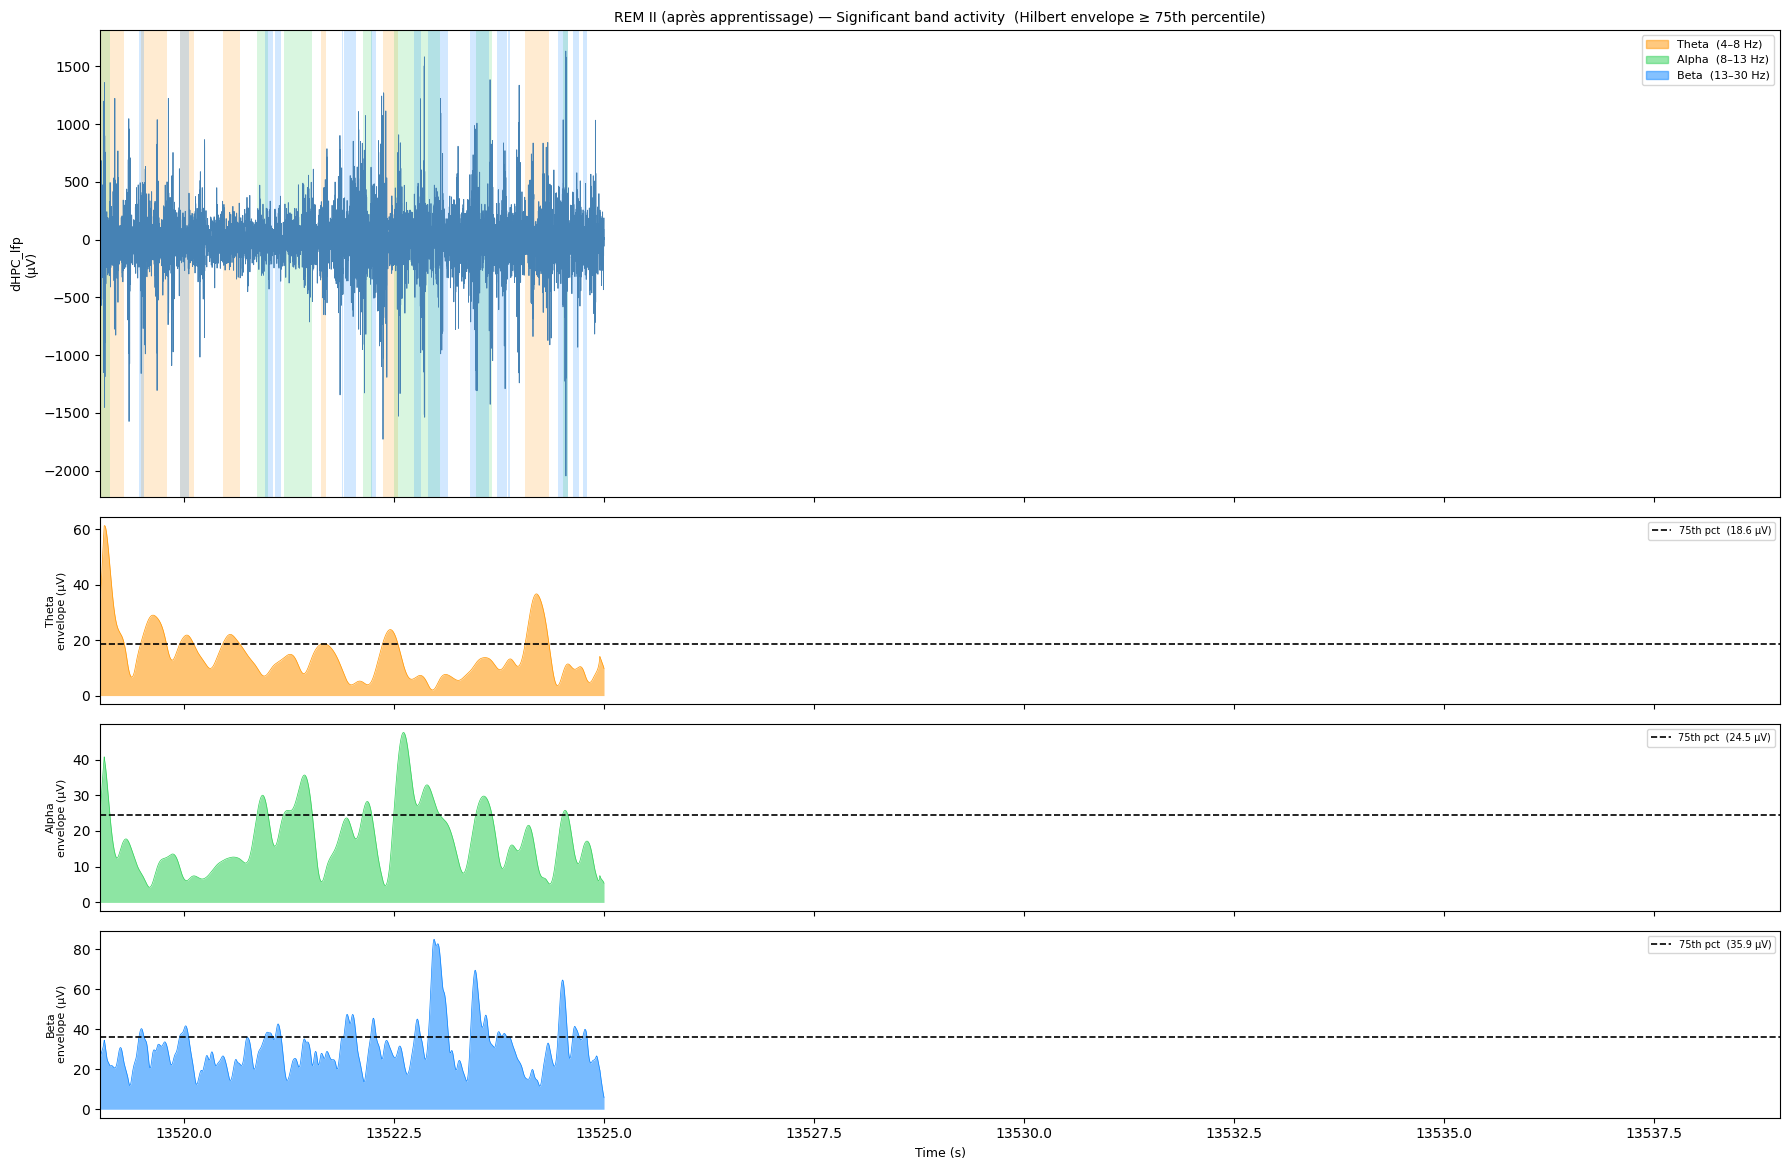

In [6]:
# --- REM I  (avant apprentissage) — epoch idx=0, fenêtre de 20 s ---
epoch_rem_pre = rem1[rem1["epoch_idx"] == 0].iloc[0]

fig_rem_pre = plot_band_activity(
    epoch_row=epoch_rem_pre,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_rem_pre["t_start"], epoch_rem_pre["t_start"] + 20),
    title_prefix="REM I (avant apprentissage)",
)
plt.show()

# --- REM II (après apprentissage) — epoch idx=0, fenêtre de 20 s ---
epoch_rem_post = rem2[rem2["epoch_idx"] == 0].iloc[0]

fig_rem_post = plot_band_activity(
    epoch_row=epoch_rem_post,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_rem_post["t_start"], epoch_rem_post["t_start"] + 20),
    title_prefix="REM II (après apprentissage)",
)
plt.show()


## 3. Comparaison PSD moyenne — NREM I vs NREM II

On calcule la densité spectrale de puissance (méthode de Welch) de **chaque
epoch**, puis on trace la moyenne ± écart-type pour chaque condition.
La bande alpha (8–13 Hz) est mise en évidence.

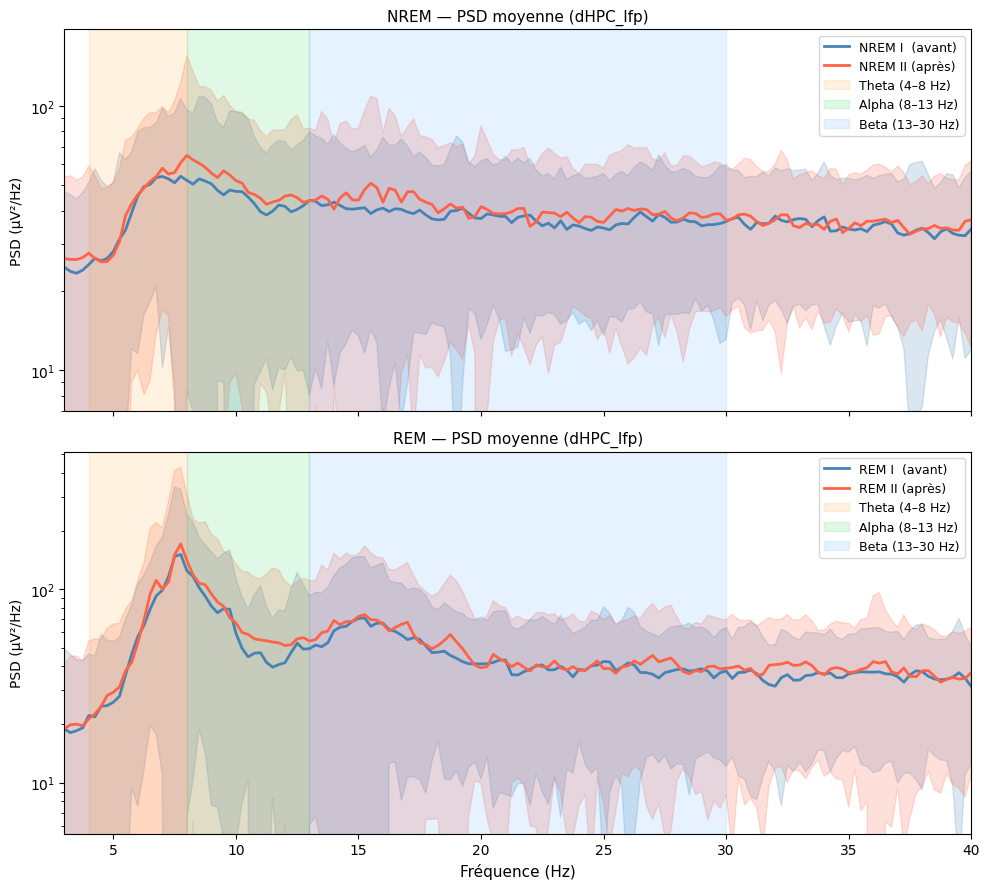

In [7]:
CHANNEL = "dHPC_lfp"

def epoch_psds(epoch_df, channel=CHANNEL, fs=FS):
    """Compute Welch PSD for every epoch row; return (freqs, psds array).

    nperseg/noverlap are clipped per-signal so no UserWarning is raised.
    All PSDs are interpolated onto a common frequency axis derived from the
    first epoch so the result can always be stacked into a 2-D array.
    """
    TARGET_NPERSEG = 4 * fs
    TARGET_NOVERLAP = 2 * fs

    psds, freqs_ref = [], None
    for _, row in epoch_df.iterrows():
        lfp = np.asarray(row[channel])
        nperseg  = min(TARGET_NPERSEG,  len(lfp))
        noverlap = min(TARGET_NOVERLAP, nperseg - 1)
        f, psd = welch(lfp, fs=fs, nperseg=nperseg, noverlap=noverlap)

        if freqs_ref is None:
            freqs_ref = f
            psds.append(psd)
        else:
            # Interpolate onto the reference frequency axis if shape differs
            if len(f) != len(freqs_ref):
                psd = np.interp(freqs_ref, f, psd)
            psds.append(psd)

    return freqs_ref, np.array(psds)


# ── Compute all PSDs once, cache by (sleep_type, channel) ─────────────────
ALL_GROUPS = {
    "NREM I":  nrem1,
    "NREM II": nrem2,
    "REM I":   rem1,
    "REM II":  rem2,
}
ALL_CHANNELS = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]

psd_cache = {}   # (label, channel) → (freqs, psds_array)
freqs = None

for label, grp in ALL_GROUPS.items():
    for ch in ALL_CHANNELS:
        f, psds = epoch_psds(grp, channel=ch)
        psd_cache[(label, ch)] = psds
        if freqs is None:
            freqs = f

# Handy aliases used by later cells
psds_nrem1 = psd_cache[("NREM I",  CHANNEL)]
psds_nrem2 = psd_cache[("NREM II", CHANNEL)]
psds_rem1  = psd_cache[("REM I",   CHANNEL)]
psds_rem2  = psd_cache[("REM II",  CHANNEL)]
psds_pre, psds_post = psds_nrem1, psds_nrem2

FMIN, FMAX = 3, 40
freq_mask = (freqs >= FMIN) & (freqs <= FMAX)

# ── PSD plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

for ax, (psd1, psd2, sleep_type) in zip(axes, [
    (psds_nrem1, psds_nrem2, "NREM"),
    (psds_rem1,  psds_rem2,  "REM"),
]):
    for label, psds, color in [
        (f"{sleep_type} I  (avant)", psd1, "steelblue"),
        (f"{sleep_type} II (après)", psd2, "tomato"),
    ]:
        mean_psd = psds.mean(axis=0)
        std_psd  = psds.std(axis=0)
        ax.semilogy(freqs[freq_mask], mean_psd[freq_mask], color=color, lw=2, label=label)
        ax.fill_between(
            freqs[freq_mask],
            np.maximum(mean_psd[freq_mask] - std_psd[freq_mask], 1e-9),
            mean_psd[freq_mask] + std_psd[freq_mask],
            alpha=0.2, color=color,
        )

    ax.axvspan(max(FREQ_BANDS["theta"][0], FMIN), min(FREQ_BANDS["theta"][1], FMAX),
               color="#FF9500", alpha=0.12, label="Theta (4–8 Hz)")
    ax.axvspan(*FREQ_BANDS["alpha"], color="#30D158", alpha=0.15, label="Alpha (8–13 Hz)")
    ax.axvspan(*FREQ_BANDS["beta"],  color="#0A84FF", alpha=0.10, label="Beta (13–30 Hz)")

    all_means = np.concatenate([psd1[:, freq_mask].mean(axis=0),
                                 psd2[:, freq_mask].mean(axis=0)])
    ax.set_ylim(all_means.min() * 0.3, all_means.max() * 3)
    ax.set_ylabel("PSD (µV²/Hz)", fontsize=10)
    ax.set_title(f"{sleep_type} — PSD moyenne ({CHANNEL})", fontsize=11)
    ax.legend(fontsize=9)

axes[-1].set_xlabel("Fréquence (Hz)", fontsize=11)
axes[-1].set_xlim(FMIN, FMAX)
plt.tight_layout()
plt.show()


## 4. Puissance alpha moyenne par epoch

Pour chaque epoch on calcule la **puissance alpha relative** :
$$P_{\alpha, rel} = \frac{\int_{8}^{13} PSD(f)\, df}{\int_{0}^{100} PSD(f)\, df}$$

Cela normalise par la puissance totale et permet de comparer des epochs
de durées différentes.

In [8]:
def band_relative_power(psd, freqs, f_low, f_high, f_total_max=100):
    """Fraction of total power in [f_low, f_high]. Returns NaN if total is zero."""
    band_mask  = (freqs >= f_low)  & (freqs <= f_high)
    total_mask = (freqs >= 0.5)    & (freqs <= f_total_max)
    total = psd[total_mask].sum()
    if total == 0 or not np.isfinite(total):
        return np.nan
    return psd[band_mask].sum() / total


alpha_lo, alpha_hi = FREQ_BANDS["alpha"]

alpha_nrem1 = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_nrem1])
alpha_nrem2 = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_nrem2])
alpha_rem1  = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_rem1])
alpha_rem2  = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_rem2])

# keep aliases used by later cells
alpha_pre, alpha_post = alpha_nrem1, alpha_nrem2

for label, pre, post in [
    ("NREM", alpha_nrem1, alpha_nrem2),
    ("REM",  alpha_rem1,  alpha_rem2),
]:
    print(f"Alpha relative power — {label} I  : {np.nanmean(pre):.4f} ± {np.nanstd(pre):.4f}  (n={len(pre)}, NaN={np.isnan(pre).sum()})")
    print(f"Alpha relative power — {label} II : {np.nanmean(post):.4f} ± {np.nanstd(post):.4f}  (n={len(post)}, NaN={np.isnan(post).sum()})")
    print()


Alpha relative power — NREM I  : 0.0483 ± 0.0250  (n=184, NaN=0)
Alpha relative power — NREM II : 0.0451 ± 0.0250  (n=203, NaN=1)

Alpha relative power — REM I  : 0.0659 ± 0.0285  (n=178, NaN=0)
Alpha relative power — REM II : 0.0604 ± 0.0289  (n=193, NaN=0)



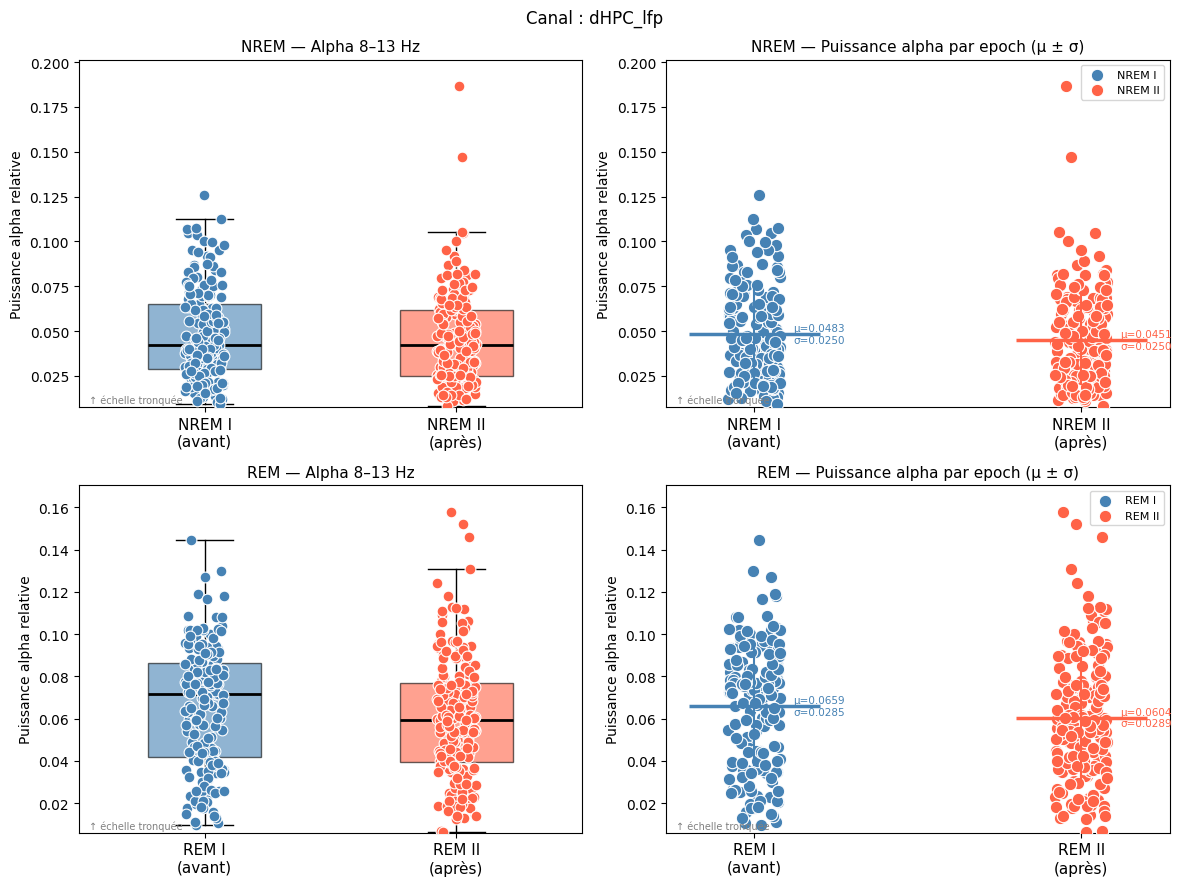

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
colors_box = ["steelblue", "tomato"]

for row, (pre, post, sleep_type) in enumerate([
    (alpha_nrem1, alpha_nrem2, "NREM"),
    (alpha_rem1,  alpha_rem2,  "REM"),
]):
    all_vals = np.concatenate([pre, post])
    y_min = np.nanmin(all_vals) * 0.92
    y_max = np.nanmax(all_vals) * 1.08

    # ── Left: boxplot ──────────────────────────────────────────────────────
    ax = axes[row, 0]
    # drop NaN before passing to boxplot
    bp = ax.boxplot(
        [pre[np.isfinite(pre)], post[np.isfinite(post)]],
        patch_artist=True, widths=0.45,
        medianprops=dict(color="black", lw=2),
        showfliers=False,
    )
    for patch, color in zip(bp["boxes"], colors_box):
        patch.set_facecolor(color); patch.set_alpha(0.6)
    for i, (vals, color) in enumerate(zip([pre, post], colors_box), start=1):
        vals_ok = vals[np.isfinite(vals)]
        jitter  = np.random.default_rng(42).uniform(-0.08, 0.08, size=len(vals_ok))
        ax.scatter(i + jitter, vals_ok, color=color, zorder=3, s=60,
                   edgecolors="white", lw=0.8)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([1, 2])
    ax.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=11)
    ax.set_ylabel("Puissance alpha relative", fontsize=10)
    ax.set_title(f"{sleep_type} — Alpha 8–13 Hz", fontsize=11)
    ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                fontsize=7, color="grey")

    # ── Right: strip plot ──────────────────────────────────────────────────
    ax2 = axes[row, 1]
    for x_center, vals, color, label in [
        (0, pre,  "steelblue", f"{sleep_type} I"),
        (1, post, "tomato",    f"{sleep_type} II"),
    ]:
        vals_ok = vals[np.isfinite(vals)]
        jitter  = np.random.default_rng(0).uniform(-0.08, 0.08, size=len(vals_ok))
        ax2.scatter(x_center + jitter, vals_ok, color=color, s=80,
                    edgecolors="white", lw=0.8, zorder=3, label=label)
        mean, std = np.nanmean(vals), np.nanstd(vals)
        ax2.hlines(mean, x_center - 0.2, x_center + 0.2, colors=color, lw=2.5, zorder=4)
        ax2.vlines(x_center, mean - std, mean + std,      colors=color, lw=1.5, zorder=4)
        ax2.annotate(f"μ={mean:.4f}\nσ={std:.4f}", xy=(x_center + 0.12, mean),
                     fontsize=7.5, color=color, va="center")
    ax2.set_ylim(y_min, y_max)
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=11)
    ax2.set_ylabel("Puissance alpha relative", fontsize=10)
    ax2.set_title(f"{sleep_type} — Puissance alpha par epoch (μ ± σ)", fontsize=11)
    ax2.legend(fontsize=8, loc="upper right")
    ax2.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                 fontsize=7, color="grey")

plt.suptitle(f"Canal : {CHANNEL}", fontsize=12)
plt.tight_layout()
plt.show()


## 4b. Contrôle : activité neuronale générale ou effet spécifique à l'alpha ?

Si la puissance augmente dans **toutes** les bandes de façon similaire, c'est probablement une hausse d'activité globale et non un effet spécifique à l'alpha.

On vérifie en deux temps :
1. **Puissance broadband absolue** (3–40 Hz) — si elle augmente entre NREM I et NREM II, les neurones sont plus actifs en général.
2. **Puissance relative de chaque bande** (theta, alpha, beta) — si alpha seule ressort, l'effet est bien spécifique.

/tmp/ipykernel_2693/2095052539.py:14: RuntimeWarning: invalid value encountered in divide
  rel[name] = psds[:, band_mask].sum(axis=1) / total


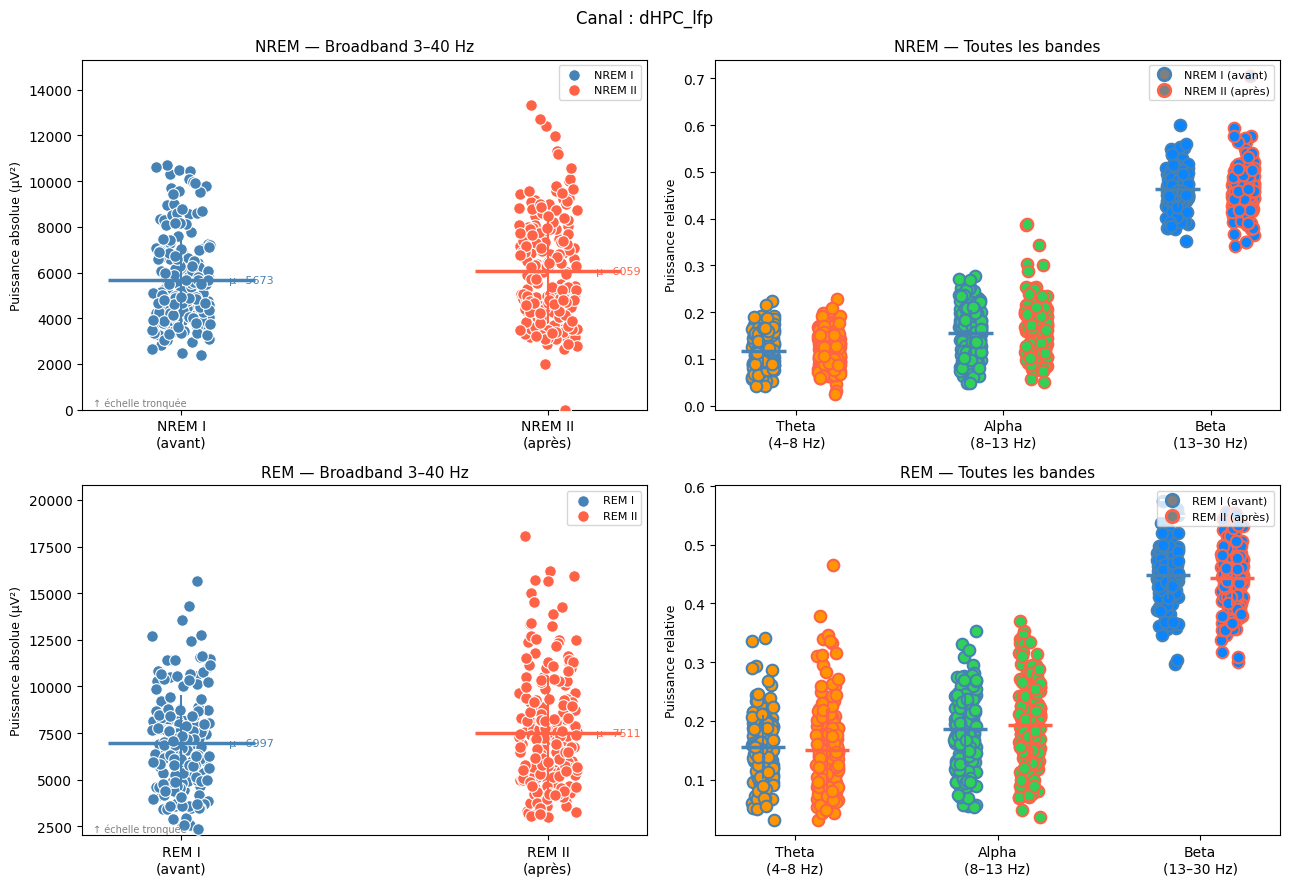

In [10]:
BANDS_ALL = {
    "theta": (4,  8),
    "alpha": (8,  13),
    "beta":  (13, 30),
}
BROADBAND = (3, 40)

def all_band_powers(psds, freqs):
    broad_mask = (freqs >= BROADBAND[0]) & (freqs <= BROADBAND[1])
    total = psds[:, broad_mask].sum(axis=1)
    rel = {}
    for name, (lo, hi) in BANDS_ALL.items():
        band_mask = (freqs >= lo) & (freqs <= hi)
        rel[name] = psds[:, band_mask].sum(axis=1) / total
    return rel, total


fig, axes = plt.subplots(2, 2, figsize=(13, 9))
band_colors = {"theta": "#FF9500", "alpha": "#30D158", "beta": "#0A84FF"}
from matplotlib.lines import Line2D

for row, sleep_type in enumerate(["NREM", "REM"]):
    psd1 = psd_cache[(f"{sleep_type} I",  CHANNEL)]
    psd2 = psd_cache[(f"{sleep_type} II", CHANNEL)]
    rel1, broad1 = all_band_powers(psd1, freqs)
    rel2, broad2 = all_band_powers(psd2, freqs)

    # ── Left: broadband absolute ───────────────────────────────────────────
    ax = axes[row, 0]
    for x_pos, vals, color, cond in [
        (0, broad1, "steelblue", f"{sleep_type} I"),
        (1, broad2, "tomato",    f"{sleep_type} II"),
    ]:
        jitter = np.random.default_rng(1).uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(x_pos + jitter, vals, color=color, s=70,
                   edgecolors="white", lw=0.8, zorder=3, label=cond)
        mean, std = vals.mean(), vals.std()
        ax.hlines(mean, x_pos - 0.2, x_pos + 0.2, colors=color, lw=2.5, zorder=4)
        ax.vlines(x_pos, mean - std,  mean + std,  colors=color, lw=1.5, zorder=4)
        ax.annotate(f"μ={mean:.0f}", xy=(x_pos + 0.13, mean),
                    fontsize=8, color=color, va="center")
    all_broad = np.concatenate([broad1, broad2])
    ax.set_ylim(all_broad.min() * 0.85, all_broad.max() * 1.15)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=10)
    ax.set_ylabel("Puissance absolue (µV²)", fontsize=9)
    ax.set_title(f"{sleep_type} — Broadband {BROADBAND[0]}–{BROADBAND[1]} Hz", fontsize=11)
    ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                fontsize=7, color="grey")
    ax.legend(fontsize=8)

    # ── Right: relative power all bands ───────────────────────────────────
    ax2 = axes[row, 1]
    band_names = list(BANDS_ALL.keys())
    group_gap, band_gap = 0.35, 1.1
    x_centers = np.arange(len(band_names)) * band_gap

    for i, name in enumerate(band_names):
        xc = x_centers[i]
        color = band_colors[name]
        for x_g, vals, edge in [
            (xc - group_gap / 2, rel1[name], "steelblue"),
            (xc + group_gap / 2, rel2[name], "tomato"),
        ]:
            jitter = np.random.default_rng(2).uniform(-0.06, 0.06, size=len(vals))
            ax2.scatter(x_g + jitter, vals, color=color, edgecolors=edge,
                        linewidths=1.5, s=70, zorder=3)
            mean, std = vals.mean(), vals.std()
            ax2.hlines(mean, x_g - 0.12, x_g + 0.12, colors=edge, lw=2.5, zorder=4)
            ax2.vlines(x_g, mean - std,  mean + std,  colors=edge, lw=1.5, zorder=4)

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
               markeredgecolor='steelblue', markeredgewidth=2, markersize=9,
               label=f"{sleep_type} I (avant)"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
               markeredgecolor='tomato', markeredgewidth=2, markersize=9,
               label=f"{sleep_type} II (après)"),
    ]
    ax2.legend(handles=legend_handles, fontsize=8, loc="upper right")
    ax2.set_xticks(x_centers)
    ax2.set_xticklabels(
        [f"{n.capitalize()}\n({BANDS_ALL[n][0]}–{BANDS_ALL[n][1]} Hz)" for n in band_names],
        fontsize=10,
    )
    ax2.set_ylabel("Puissance relative", fontsize=9)
    ax2.set_title(f"{sleep_type} — Toutes les bandes", fontsize=11)

plt.suptitle(f"Canal : {CHANNEL}", fontsize=12)
plt.tight_layout()
plt.show()


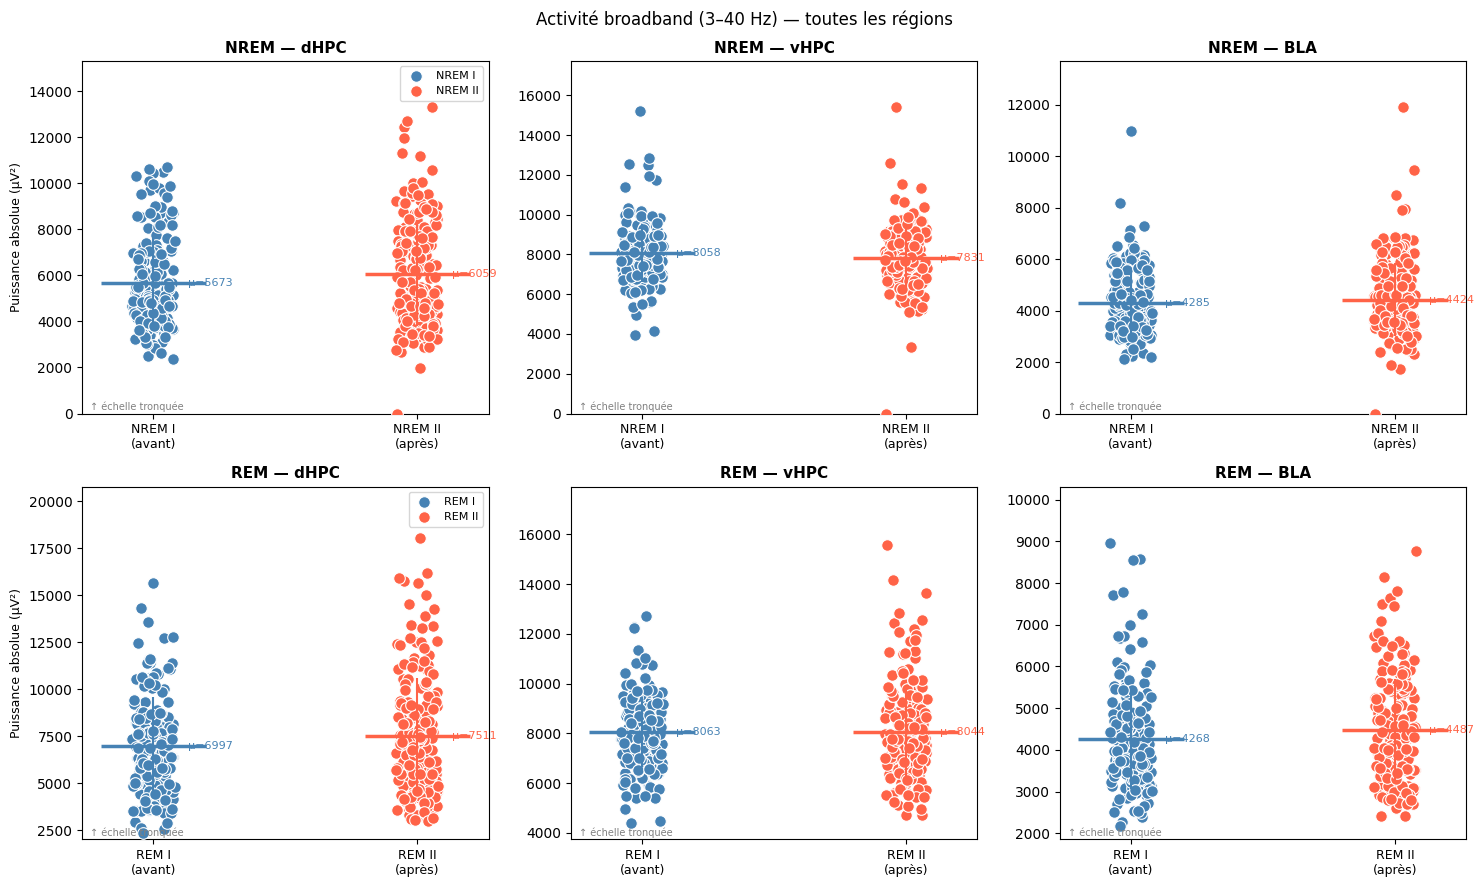

In [11]:
channels       = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
channel_labels = ["dHPC",     "vHPC",     "BLA"]

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for row, sleep_type in enumerate(["NREM", "REM"]):
    for col, (ch, ch_label) in enumerate(zip(channels, channel_labels)):
        ax   = axes[row, col]
        # Read from cache — no recomputation
        pre  = psd_cache[(f"{sleep_type} I",  ch)]
        post = psd_cache[(f"{sleep_type} II", ch)]

        broad_mask = (freqs >= BROADBAND[0]) & (freqs <= BROADBAND[1])
        broad_pre  = pre[:,  broad_mask].sum(axis=1)
        broad_post = post[:, broad_mask].sum(axis=1)

        for x_pos, vals, color, cond in [
            (0, broad_pre,  "steelblue", f"{sleep_type} I"),
            (1, broad_post, "tomato",    f"{sleep_type} II"),
        ]:
            jitter = np.random.default_rng(3).uniform(-0.08, 0.08, size=len(vals))
            ax.scatter(x_pos + jitter, vals, color=color, s=70,
                       edgecolors="white", lw=0.8, zorder=3, label=cond)
            mean, std = vals.mean(), vals.std()
            ax.hlines(mean, x_pos - 0.2, x_pos + 0.2, colors=color, lw=2.5, zorder=4)
            ax.vlines(x_pos, mean - std,  mean + std,  colors=color, lw=1.5, zorder=4)
            ax.annotate(f"μ={mean:.0f}", xy=(x_pos + 0.13, mean),
                        fontsize=8, color=color, va="center")

        all_vals = np.concatenate([broad_pre, broad_post])
        ax.set_ylim(all_vals.min() * 0.85, all_vals.max() * 1.15)
        ax.set_xticks([0, 1])
        ax.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=9)
        ax.set_title(f"{sleep_type} — {ch_label}", fontsize=11, fontweight="bold")
        ax.set_ylabel("Puissance absolue (µV²)" if col == 0 else "", fontsize=9)
        ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                    fontsize=7, color="grey")
        if col == 0:
            ax.legend(fontsize=8)

plt.suptitle(f"Activité broadband ({BROADBAND[0]}–{BROADBAND[1]} Hz) — toutes les régions",
             fontsize=12)
plt.tight_layout()
plt.show()


## 5. Comparaison multi-canaux

Est-ce que le changement est spécifique à une région cérébrale ?
On répète le calcul pour dHPC, vHPC et BLA.

In [12]:
channels       = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
channel_labels = ["dHPC",     "vHPC",     "BLA"]

# Re-use psd_cache — no extra Welch calls
results = {}
for ch in channels:
    results[ch] = {
        "pre":  np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi)
                          for p in psd_cache[("NREM I",  ch)]]),
        "post": np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi)
                          for p in psd_cache[("NREM II", ch)]]),
    }


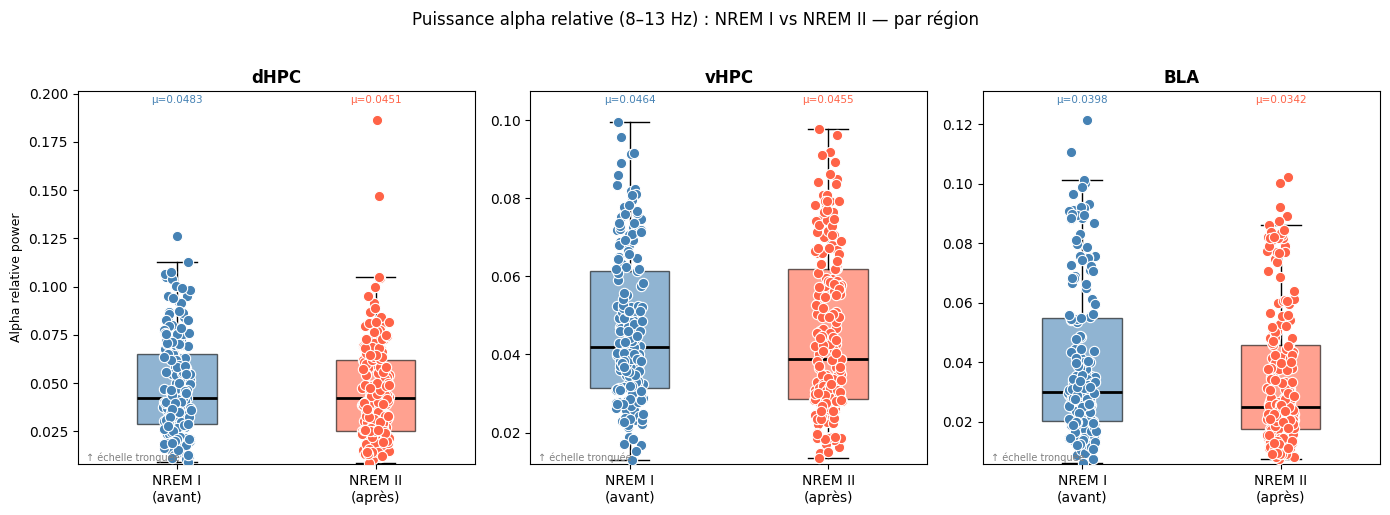

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

for ax, ch, label in zip(axes, channels, channel_labels):
    pre  = results[ch]["pre"]
    post = results[ch]["post"]

    bp = ax.boxplot(
        [pre[np.isfinite(pre)], post[np.isfinite(post)]],
        patch_artist=True, widths=0.4,
        medianprops=dict(color="black", lw=2),
        showfliers=False,
    )
    for patch, color in zip(bp["boxes"], ["steelblue", "tomato"]):
        patch.set_facecolor(color); patch.set_alpha(0.6)

    for i, (vals, color) in enumerate(zip([pre, post], ["steelblue", "tomato"]), start=1):
        vals_ok = vals[np.isfinite(vals)]
        jitter  = np.random.default_rng(42).uniform(-0.07, 0.07, size=len(vals_ok))
        ax.scatter(i + jitter, vals_ok, color=color, zorder=3, s=55,
                   edgecolors="white", lw=0.8)

    all_vals = np.concatenate([pre, post])
    ax.set_ylim(np.nanmin(all_vals) * 0.92, np.nanmax(all_vals) * 1.08)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=10)
    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_ylabel("Alpha relative power" if ch == channels[0] else "", fontsize=9)
    ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                fontsize=7, color="grey")

    for x_pos, vals, color in [(1, pre, "steelblue"), (2, post, "tomato")]:
        ax.text(x_pos, ax.get_ylim()[1] * 0.99,
                f"μ={np.nanmean(vals):.4f}",
                ha="center", va="top", fontsize=7.5, color=color)

plt.suptitle("Puissance alpha relative (8–13 Hz) : NREM I vs NREM II — par région",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


## 6. Évolution temporelle de la puissance alpha au sein d'une epoch

On utilise `detect_significant_band_epochs` pour obtenir l'enveloppe
instantanée et on compare la dynamique intra-epoch entre NREM I et NREM II.

On prend l'epoch la plus longue de chaque condition et on re-normalise
le temps entre 0 et 1 pour faciliter la comparaison.

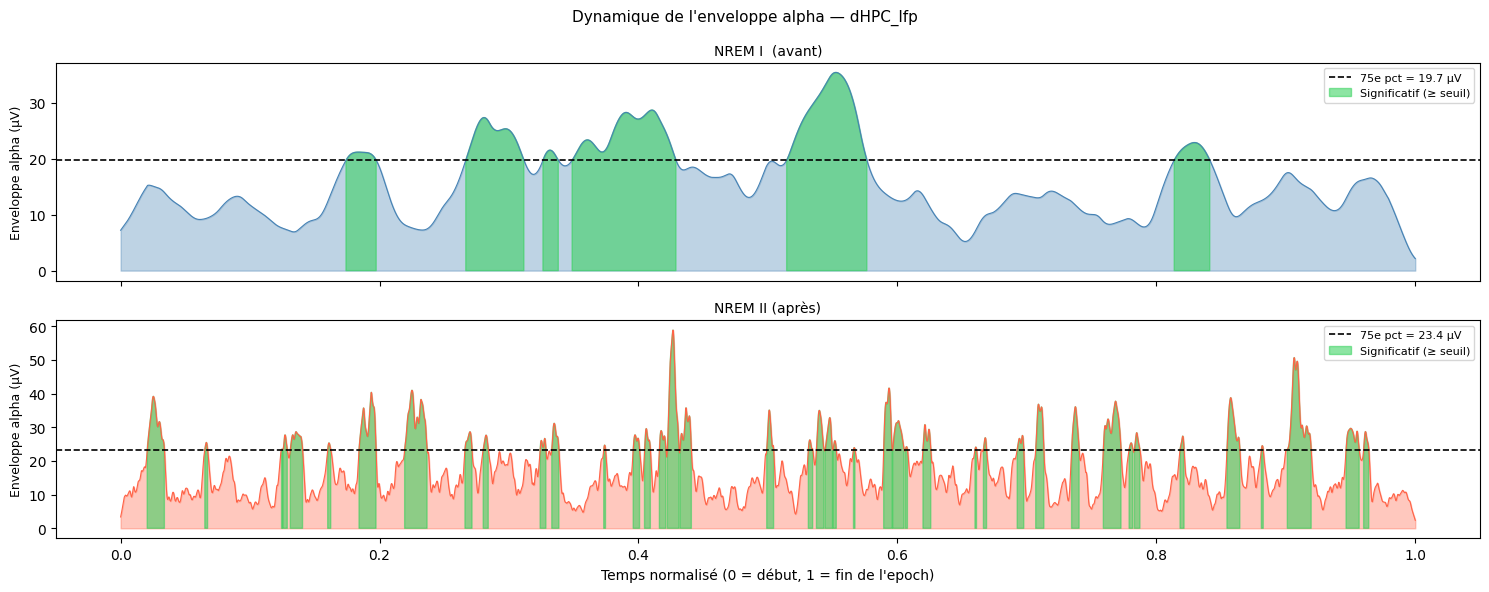

Fraction de temps au-dessus du seuil alpha :
  NREM I  : 25.0 %
  NREM II : 25.0 %


In [14]:
# Pick a representative epoch from each condition (similar duration ~120–140 s)
ep_pre_ex  = nrem1[nrem1["epoch_idx"] == 5].iloc[0]   # 139 s
ep_post_ex = nrem2[nrem2["epoch_idx"] == 1].iloc[0]   # 120 s

alpha_bands = {"alpha": FREQ_BANDS["alpha"]}

def get_alpha_envelope(epoch_row, channel=CHANNEL, fs=FS):
    lfp = np.asarray(epoch_row[channel])
    res = detect_significant_band_epochs(
        lfp, fs,
        t_start=float(epoch_row["t_start"]),
        smooth_sec=0.5,          # smoother trace for visualisation
        threshold_percentile=75,
        bands=alpha_bands,
    )
    times    = res["times"]
    envelope = res["envelopes"]["alpha"]
    thr      = res["thresholds"]["alpha"]
    sig      = res["significant"]["alpha"]
    # Normalise time to [0, 1]
    t_norm = (times - times[0]) / (times[-1] - times[0])
    return t_norm, envelope, thr, sig


t_pre,  env_pre,  thr_pre,  sig_pre  = get_alpha_envelope(ep_pre_ex)
t_post, env_post, thr_post, sig_post = get_alpha_envelope(ep_post_ex)

fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

for ax, t, env, thr, sig, label, color in [
    (axes[0], t_pre,  env_pre,  thr_pre,  sig_pre,  "NREM I  (avant)", "steelblue"),
    (axes[1], t_post, env_post, thr_post, sig_post, "NREM II (après)", "tomato"),
]:
    # Plot envelope
    ax.fill_between(t, env, alpha=0.35, color=color)
    ax.plot(t, env, lw=0.8, color=color)
    # Threshold line
    ax.axhline(thr, color="black", lw=1.2, ls="--",
               label=f"75e pct = {thr:.1f} µV")
    # Shade significant regions
    ax.fill_between(t, 0, env, where=sig, alpha=0.55,
                    color="#30D158", label="Significatif (≥ seuil)")
    ax.set_ylabel("Enveloppe alpha (µV)", fontsize=9)
    ax.set_title(label, fontsize=10)
    ax.legend(fontsize=8, loc="upper right")

axes[1].set_xlabel("Temps normalisé (0 = début, 1 = fin de l'epoch)", fontsize=10)
plt.suptitle(f"Dynamique de l'enveloppe alpha — {CHANNEL}", fontsize=11)
plt.tight_layout()
plt.show()

# Fraction of time above threshold
frac_pre  = sig_pre.mean() * 100
frac_post = sig_post.mean() * 100
print(f"Fraction de temps au-dessus du seuil alpha :")
print(f"  NREM I  : {frac_pre:.1f} %")
print(f"  NREM II : {frac_post:.1f} %")

---
## Résumé

| | NREM I (avant) | NREM II (après) |
|---|---|---|
| Epochs | 8 | 5 |
| Puissance alpha relative dHPC | voir cellule 4 | voir cellule 4 |
| Fraction de temps alpha significatif | voir cellule 6 | voir cellule 6 |

**Lecture des résultats**
- Si NREM II > NREM I → l'apprentissage a augmenté l'activité alpha pendant le sommeil.
- Comparez les trois régions (dHPC, vHPC, BLA) : un effet localisé dans le dHPC ou le vHPC serait biologiquement cohérent avec la consolidation mnésique hippocampique.
- Explorez aussi les bandes theta et beta avec la même approche !

Pour aller plus loin : comparez la condition **neutral** (`lfp_data.pkl`) avec la condition **aversive** (`lfp_epochs_with_spikes_by_region_aversive.pkl`).